<a href="https://colab.research.google.com/github/dsgustavomoreira/CNN-Visao-Computacional/blob/main/CNN_Vis%C3%A3o_Computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN - Visão Computacional - Reconhecimento Cães e Gatos**

In [ ]:
import os                              # Importa o módulo os para interagir com o sistema operacional.
import shutil                          # Importa o módulo shutil para operações de arquivo de alto nível (por exemplo, copiar, mover).
import cv2                             # Importa OpenCV, uma biblioteca para processamento de imagem e visão computacional.
import numpy as np                     # Importa NumPy, uma biblioteca para operações matemáticas e manipulação de arrays.
import pandas as pd                    # Importa Pandas, uma biblioteca para manipulação e análise de dados.
import matplotlib.pyplot as plt       # Importa a biblioteca Matplotlib para criação de gráficos e visualizações.

# Importações relacionadas ao Keras (uma biblioteca de Deep Learning):
from keras.models import Sequential    # Importa o modelo sequencial do Keras, uma pilha linear de camadas.
from keras.layers import Conv2D        # Importa a camada Conv2D, usada para operações de convolução em imagens.
from keras.layers import MaxPooling2D  # Importa a camada MaxPooling2D, usada para operações de pooling (redução de dimensionalidade).
from keras.layers import Flatten       # Importa a camada Flatten, usada para converter o formato de matriz 2D para vetor 1D.
from keras.layers import Dense         # Importa a camada Dense, uma camada regular de neurônios totalmente conectada.
from keras.preprocessing.image import ImageDataGenerator  # Ferramenta para preparação e aumento de dados de imagem.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from PIL import Image

# Importações relacionadas à avaliação do modelo:
from sklearn.metrics import classification_report, confusion_matrix  # Ferramentas para avaliar a performance do modelo.

# **1. Problema de Negócio:** Reconhecimento de Imagens de Cães e Gatos

# **2 - Análise dos Dados**

Link para Base de Dados: https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/data

In [ ]:
!mkdir -p /root/.kaggle/
!mv kaggle.json /root/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 98% 798M/814M [00:14<00:00, 47.7MB/s]
100% 814M/814M [00:14<00:00, 58.2MB/s]


In [ ]:
!unzip -qq /content/dogs-vs-cats-redux-kernels-edition.zip
!unzip -qq train.zip
!unzip -qq test.zip

In [ ]:
!mkdir train/cat
!mkdir train/dog

In [ ]:
# Criando caminhos para as pastas de Treino e Teste
dir_treino = os.path.join(os.getcwd(), 'train')
dir_teste = os.path.join(os.getcwd(), 'test')

# Criando caminhos para as pastas de gatos e cães na pasta de Treino
dir_treino_cats = os.path.join(dir_treino, 'cat')
dir_treino_dogs = os.path.join(dir_treino, 'dog')

In [ ]:
# Função para mover as imagens com base no nome do arquivo
def move_images_based_on_filename(scr_dir, dest_dir_cats, dest_dir_dogs):
  for filename in os.listdir(scr_dir):
    if filename.endswith(".jpg"):
      # Verifica se o nome do arquivo tem 'gato' ou 'cão'
      animal_class = filename.split('.')[0]
      scr_path = os.path.join(scr_dir, filename)

      # Move a imagem para o diretório apropriado
      if animal_class == 'cat':
        dest_path = os.path.join(dest_dir_cats, filename)
      elif animal_class == 'dog':
        dest_path = os.path.join(dest_dir_dogs, filename)
      else:
        continue

      # Move a imagem
      shutil.move(scr_path, dest_path)

In [ ]:
# Move as imagens de treino com base no nome do arquivo
move_images_based_on_filename(dir_treino, dir_treino_cats, dir_treino_dogs)

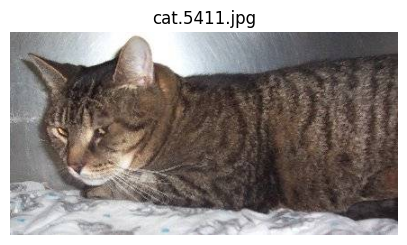

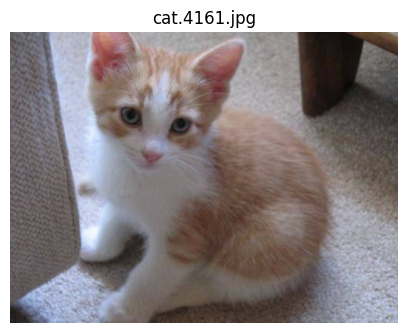

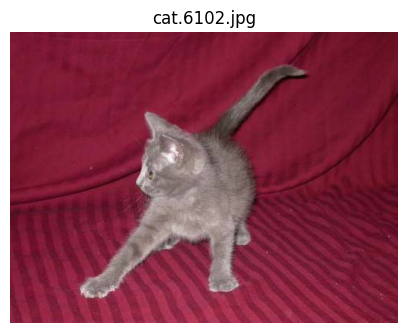

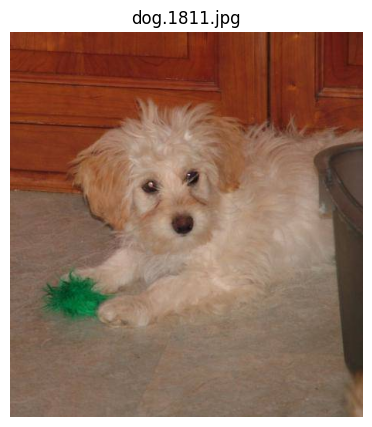

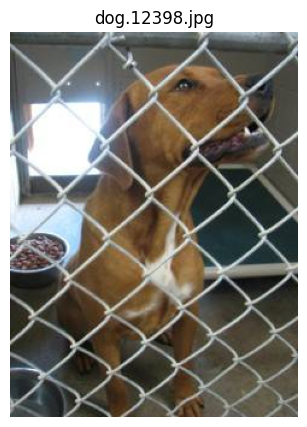

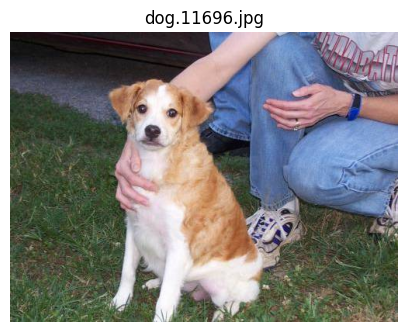

In [ ]:
# Diretórios das imagens de treinamento
dir_treino_cats = '/content/train/cat'
dir_treino_dogs = '/content/train/dog'

# Função para carregar e exibir as imagens
def load_and_display_images(directory, num_images=3):
  image_files = os.listdir(directory)

  # Carrega e exibe as primeiras imagens
  for i in range(num_images):
    if i >= len(image_files):
        break
    image_path = os.path.join(directory, image_files[i])
    image = cv2.imread(image_path)
    if image is not None:
        plt.figure(figsize=(5,5))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(image_files[i])
        plt.show()

# Carrega e exibe 3 imagens de gatos
load_and_display_images(dir_treino_cats)

# Carrega e exibe 3 imagens de cães
load_and_display_images(dir_treino_dogs)

In [ ]:
# Diretórios das imagens de treinamento
dir_treino_cats = '/content/train/cat'
dir_treino_dogs = '/content/train/dog'

# Contagem de amostras em cada classe
num_cats = len(os.listdir(dir_treino_cats))
num_dogs = len(os.listdir(dir_treino_dogs))

print("O número de amostras de gatos é: ", num_cats)
print("O número de amostras de cães é: ", num_dogs)

O número de amostras de gatos é:  12500
O número de amostras de cães é:  12500


# **3 - Processamento dos Dados**

In [ ]:
# Diretórios das imagens de treinamento e teste
dir_treino_cats = '/content/train/cat'
dir_treino_dogs = '/content/train/dog'
dir_teste = '/content/test'

# Lista para armazenar imagens e rótulos correspondentes
images = []
labels = []

# Função para carregar e redimensionar imagens
def load_and_resize_image(image_path):
  image = cv2.imread(image_path)
  if image is not None:
    image = cv2.resize(image, (64, 64))
    return image
  else:
    return None

# Carregar imagens de gatos
for filename in os.listdir(dir_treino_cats):
    if filename.endswith(".jpg"):
        image_path = os.path.join(dir_treino_cats, filename)
        image = load_and_resize_image(image_path)
        if image is not None:
          images.append(image)
          labels.append(0)

# Carregar imagens de cães
for filename in os.listdir(dir_treino_dogs):
    if filename.endswith(".jpg"):
        image_path = os.path.join(dir_treino_dogs, filename)
        image = load_and_resize_image(image_path)
        if image is not None:
          images.append(image)
          labels.append(1)


In [ ]:
# Converte as listas em arrays numpy
images = np.array(images)
labels = np.array(labels)

# Verifica se há imagens e rótulos suficientes
if len(images) == 0:
  print('Não há imagens válidas para o treinamento')
else:
    # Divide o conjunto de dados em treinamento e validação
    split_ratio = 0.2
    split_idx = int(len(images) * (1 - split_ratio))
    x_train, x_val = images[:split_idx], images[split_idx:]
    y_train, y_val = labels[:split_idx], labels[split_idx:]

# Processamento dos Dados
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1. / 255)

# Para utilizar o modelo com Transfer Learning 'pular' para seção 'Transferência de Aprendizado'

In [ ]:
len(x_train)

20000

In [ ]:
len(y_train)

20000

# **4 - Construção da Máquina Preditiva - IA com Deep Learning**

In [ ]:
# Construção do modelo CNN
cnn = Sequential()
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(64, 64, 3)))
cnn.add(MaxPooling2D(pool_size=2, strides=2))
cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=2, strides=2))
cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=2, strides=2))
cnn.add(Flatten())
cnn.add(Dense(units=128, activation='relu'))
cnn.add(Dropout(0.5))  # Dropout para regularização
cnn.add(Dense(units=1, activation='sigmoid'))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
len(x_train)

20000

In [ ]:
len(y_train)

20000

In [ ]:
# Treinamento do modelo
history = cnn.fit(train_datagen.flow(x_train, y_train, batch_size=32), epochs=6,
                  validation_data=val_datagen.flow(x_val, y_val, batch_size=32))

Epoch 1/6
625/625 [==============================] - 41s 50ms/step - loss: 0.6409 - accuracy: 0.6400 - val_loss: 0.7682 - val_accuracy: 0.5066
Epoch 2/6
625/625 [==============================] - 30s 49ms/step - loss: 0.5907 - accuracy: 0.6925 - val_loss: 0.7286 - val_accuracy: 0.5488
Epoch 3/6
625/625 [==============================] - 30s 49ms/step - loss: 0.5480 - accuracy: 0.7261 - val_loss: 0.6193 - val_accuracy: 0.6422
Epoch 4/6
625/625 [==============================] - 31s 50ms/step - loss: 0.5149 - accuracy: 0.7474 - val_loss: 0.3932 - val_accuracy: 0.8192
Epoch 5/6
625/625 [==============================] - 30s 49ms/step - loss: 0.4892 - accuracy: 0.7724 - val_loss: 0.4952 - val_accuracy: 0.7602
Epoch 6/6
625/625 [==============================] - 31s 49ms/step - loss: 0.4714 - accuracy: 0.7808 - val_loss: 0.3829 - val_accuracy: 0.8220


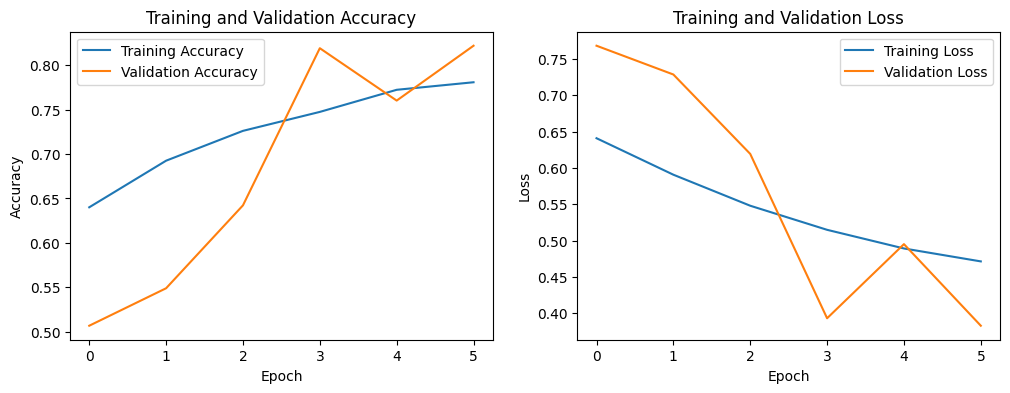

157/157 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.82      0.90      5000

    accuracy                           0.82      5000
   macro avg       0.50      0.41      0.45      5000
weighted avg       1.00      0.82      0.90      5000

[[   0    0]
 [ 890 4110]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Curvas de acurácia e perda
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Avaliação do modelo
y_pred_probs = cnn.predict(val_datagen.flow(x_val, batch_size=32))

# Definição do limite de decisão
threshold= 0.5

# Criação das previsões binárias com base no limite de decisão
y_pred = (y_pred_probs > threshold).astype(int).flatten()

print(classification_report(y_val, y_pred))

# Matriz de confusão
confusion_mtx = confusion_matrix(y_val, y_pred)
print(confusion_mtx)

# **5 - Aprimoramento do Modelo Base**

In [ ]:
# Construção do NOVO Modelo Base

# Diretórios das imagens de treinamento e teste
dir_treino_cats = '/content/train/cat'
dir_treino_dogs = '/content/train/dog'
dir_teste = '/content/test'

# Lista para armazenar imagens e rótulos correspondentes
images = []
labels = []

# Função para carregar e redimensionar imagens
def load_and_resize_image(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        # Redimensionar a imagem para 64x64 pixels
        image = cv2.resize(image, (64, 64))
        return image
    else:
        return None

# Carregar imagens de gatos
for filename in os.listdir(dir_treino_cats):
    if filename.endswith(".jpg"):
        image_path = os.path.join(dir_treino_cats, filename)
        image = load_and_resize_image(image_path)
        if image is not None:
            images.append(image)
            labels.append(0)  # Gato

# Carregar imagens de cães
for filename in os.listdir(dir_treino_dogs):
    if filename.endswith(".jpg"):
        image_path = os.path.join(dir_treino_dogs, filename)
        image = load_and_resize_image(image_path)
        if image is not None:
            images.append(image)
            labels.append(1)  # Cão

# Converta as listas em arrays numpy
images = np.array(images)
labels = np.array(labels)

# Verifique se há imagens e rótulos suficientes
if len(images) == 0:
    print("Não há imagens válidas para treinamento.")
else:
    # Dividir o conjunto de dados em treinamento e validação
    x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Data Preprocessing
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,  # Rotação aleatória
        width_shift_range=0.2,  # Deslocamento horizontal aleatório
        height_shift_range=0.2,  # Deslocamento vertical aleatório
        horizontal_flip=True
    )

cnn = Sequential()
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(64, 64, 3)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=2, strides=2))
cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=2, strides=2))
cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=2, strides=2))
cnn.add(Flatten())
cnn.add(Dense(units=128, activation='relu'))
cnn.add(Dropout(0.5))  # Dropout para regularização
cnn.add(Dense(units=1, activation='sigmoid'))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compilando o modelo com um otimizador ADAM ajustando a taxa de aprendizado
optimizer = Adam(learning_rate=0.001)
cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Treinamento do NOVO modelo Base
history = cnn.fit(train_datagen.flow(x_train, y_train, batch_size=32), epochs=5,
                  validation_data=val_datagen.flow(x_val, y_val, batch_size=32))

Epoch 1/5
625/625 [==============================] - 35s 51ms/step - loss: 0.6834 - accuracy: 0.6219 - val_loss: 0.5851 - val_accuracy: 0.6972
Epoch 2/5
625/625 [==============================] - 31s 50ms/step - loss: 0.6000 - accuracy: 0.6793 - val_loss: 0.6057 - val_accuracy: 0.6636
Epoch 3/5
625/625 [==============================] - 31s 49ms/step - loss: 0.5479 - accuracy: 0.7268 - val_loss: 0.7659 - val_accuracy: 0.6236
Epoch 4/5
625/625 [==============================] - 31s 50ms/step - loss: 0.5156 - accuracy: 0.7485 - val_loss: 0.4352 - val_accuracy: 0.7928
Epoch 5/5
625/625 [==============================] - 31s 50ms/step - loss: 0.4901 - accuracy: 0.7659 - val_loss: 0.4904 - val_accuracy: 0.7926


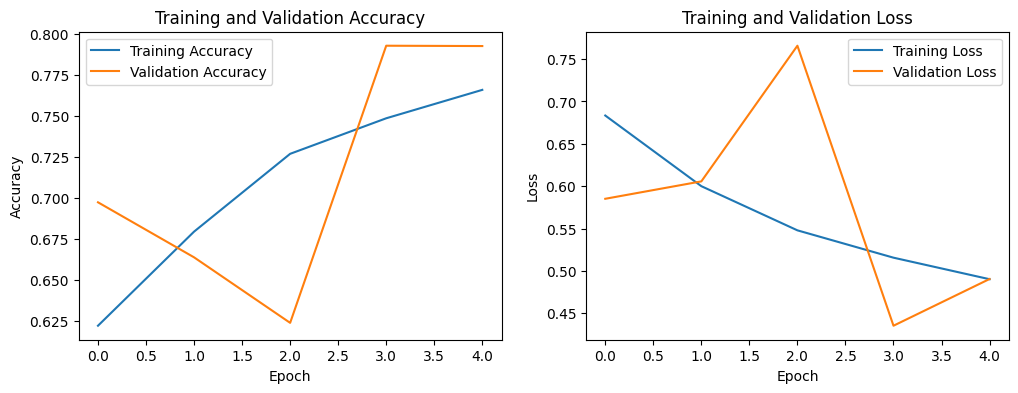

157/157 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      2515
           1       0.48      0.47      0.48      2485

    accuracy                           0.49      5000
   macro avg       0.49      0.49      0.49      5000
weighted avg       0.49      0.49      0.49      5000

[[1259 1256]
 [1309 1176]]


In [ ]:
# Curvas de acurácia e perda do NOVO Modelo
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Avaliação do modelo
y_pred_probs = cnn.predict(val_datagen.flow(x_val, batch_size=32))

# Definição do limite de decisão
threshold= 0.5

# Criação das previsões binárias com base no limite de decisão
y_pred = (y_pred_probs > threshold).astype(int).flatten()

print(classification_report(y_val, y_pred))

# Matriz de confusão
confusion_mtx = confusion_matrix(y_val, y_pred)
print(confusion_mtx)

# **6 - Modelo utilizando Transferência de Aprendizado**

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/5
1250/1250 [==============================] - 120s 91ms/step - loss: 0.5170 - accuracy: 0.7494 - val_loss: 0.3773 - val_accuracy: 0.8620
Epoch 2/5
1250/1250 [==============================] - 115s 92ms/step - loss: 0.4282 - accuracy: 0.8051 - val_loss: 0.3376 - val_accuracy: 0.8688
Epoch 3/5
1250/1250 [==============================] - 112s 90ms/step - loss: 0.4085 - accuracy: 0.8145 - val_loss: 0.3154 - val_accuracy: 0.8746
Epoch 4/5
1250/1250 [==============================] - 112s 89ms/step - loss: 0.4001 - accuracy: 0.8178 - val_loss: 0.3091 - val_accuracy: 0.8766
Epoch 5/5
1250/1250 [==============================] - 112s 90ms/step - loss: 0.3980 - accuracy: 0.8182 - val_loss: 0.3030 - val_accuracy: 0.8786


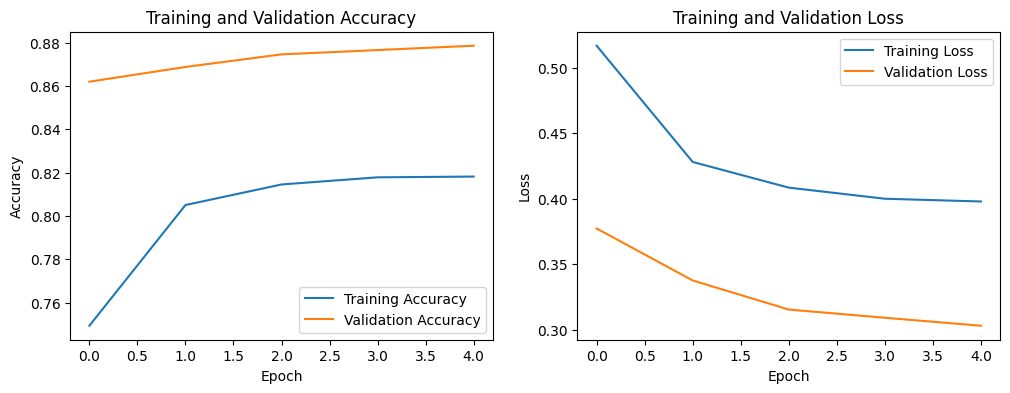

157/157 [==============================] - 11s 45ms/step
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      2515
           1       0.50      0.49      0.49      2485

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000

[[1288 1227]
 [1278 1207]]


In [ ]:
# Construção do Modelo com Transferência de Aprendizado

# Diretórios das imagens de treinamento e teste
dir_treino_cats = '/content/train/cat'
dir_treino_dogs = '/content/train/dog'
dir_teste = '/content/test'

# Lista para armazenar imagens e rótulos correspondentes
images = []
labels = []

# Função para carregar e redimensionar imagens
def load_and_resize_image(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        # Redimensionar a imagem para o formato esperado pelo VGG16
        image = cv2.resize(image, (128, 128))
        return image
    else:
        return None

# Carregar imagens de gatos
for filename in os.listdir(dir_treino_cats):
    if filename.endswith(".jpg"):
        image_path = os.path.join(dir_treino_cats, filename)
        image = load_and_resize_image(image_path)
        if image is not None:
            images.append(image)
            labels.append(0)  # Gato

# Carregar imagens de cães
for filename in os.listdir(dir_treino_dogs):
    if filename.endswith(".jpg"):
        image_path = os.path.join(dir_treino_dogs, filename)
        image = load_and_resize_image(image_path)
        if image is not None:
            images.append(image)
            labels.append(1)  # Cão

# Converta as listas em arrays numpy
images = np.array(images)
labels = np.array(labels)

# Verifique se há imagens e rótulos suficientes
if len(images) == 0:
    print("Não há imagens válidas para treinamento.")
else:
    # Dividir o conjunto de dados em treinamento e validação
    x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Data Preprocessing
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(rescale=1. / 255)

# Carregar o modelo VGG16 pré-treinado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Construir um novo modelo em cima do VGG16
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Congelar as camadas do modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compile o modelo com um otimizador Adam ajustando a taxa de aprendizado
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Treinamento do modelo com aumento de dados
history = model.fit(train_datagen.flow(x_train, y_train, batch_size=16), epochs=5,
                        validation_data=val_datagen.flow(x_val, y_val, batch_size=16))

# Curvas de acurácia e perda do Modelo com TRANSFERÊNCIA DE APRENDIZADO
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Avaliação do modelo
y_pred_probs = model.predict(val_datagen.flow(x_val, batch_size=32))

# Definição do limite de decisão
threshold= 0.5

# Criação das previsões binárias com base no limite de decisão
y_pred = (y_pred_probs > threshold).astype(int).flatten()

print(classification_report(y_val, y_pred))

# Matriz de confusão
confusion_mtx = confusion_matrix(y_val, y_pred)
print(confusion_mtx)

OBS.: Tendo em vista a impossibilidade da utilização de TPU ou TPU4 no Google Colab no momento desta importação, os resultados do Modelo utilizando Transferência de Aprendizado não puderam ser disponibilizados. No entanto, de acordo com testes realizados anteriormente à indisponibilidade do serviço verificou-se que tanto o F1Score quanto a Acurácia foram superiores aos modelos testados inicialmente. Tão breve haja disponibilidade das referidas TPUs os resultados do modelo serão apresentados.



# **7 - Salvamento e Teste da Máquina Preditiva**

In [ ]:
model.save('modelo_cat_dog.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
modelo_carregado = load_model('modelo_cat_dog.h5')

In [ ]:
# Função para prever se a imagem é um cachorro ou gato
def prever(imagem_path, modelo):
  image = load_and_resize_image(image_path)
  if image is not None:
      image = np.expand_dims(image, axis=0)
      image = image / 255.0
      previsao = modelo.predict(image)[0][0]
      return previsao, 'cat' if previsao < 0.5 else 'dog'
  else:
      return None, None

In [ ]:
# Teste da função com uma imagem
image_file = '/content/test/1.jpg'
previsao, classe = prever(image_file, modelo_carregado)

if previsao is not None and classe is not None:
    print(f'Previsão: {previsao} | {classe}')
else:
    print('Erro ao prever a imagem.')

1/1 [==============================] - 2s 2s/step
Previsão: 0.9885501265525818 | dog


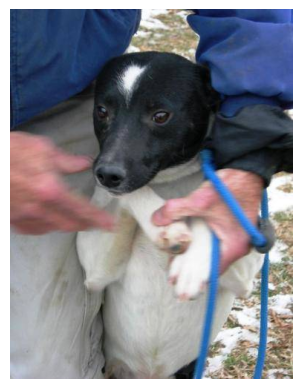

In [ ]:
# Carregamento da imagem
image = Image.open('/content/test/1.jpg')

# Exibição da imagem
plt.imshow(image)
plt.axis('off')
plt.show()